# PCA for dimensionality reduction

One of the primary uses for principal component analysis (PCA) is reducing the number of dimensions in high-dimensional data. In this example, we turn a 2D dataset into a 1D dataset.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

(-2.7391278364515688,
 2.5801310701596343,
 -0.9477947579593762,
 1.019590430670684)

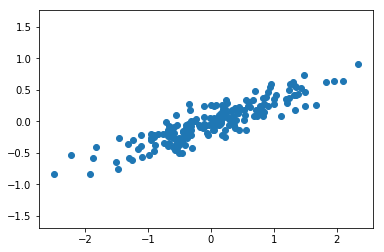

In [2]:
# Generate random data points that roughly form a line
rng = np.random.RandomState(1)
x = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(x[:, 0], x[:, 1])
plt.axis('equal')

In [3]:
# Find two principal components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(x)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

(-2.7391278364515688,
 2.5801310701596343,
 -0.9477947579593762,
 1.019590430670684)

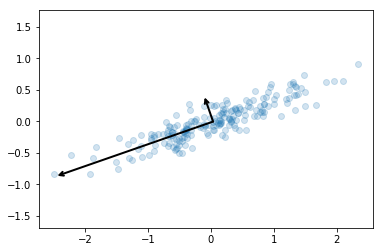

In [4]:
# Plot the principal components
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    props = dict(arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=props)
    
plt.scatter(x[:, 0], x[:, 1], alpha=0.2)

for len, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(len)
    draw_vector(pca.mean_, pca.mean_ + v)

plt.axis('equal')

In [5]:
# Use PCA to reduce two dimensions to one while retaining most of the information
pca = PCA(n_components=1)
pca.fit(x)
x_pca = pca.transform(x)

(-2.771528780690219, 2.661757596590677, -0.9964674432667124, 1.021908177590081)

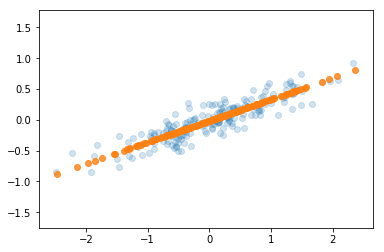

In [6]:
# Plot the results
x_new = pca.inverse_transform(x_pca)
plt.scatter(x[:, 0], x[:, 1], alpha=0.2)
plt.scatter(x_new[:, 0], x_new[:, 1], alpha=0.8)
plt.axis('equal')

# PCA for noise reduction

PCA is is also useful for filtering noise from data. The basic approach is to PCA-transform the dataset, and then perform an inverse transform. Here we demonstrate by artificially adding noise to the handwritten-digits dataset included with scikit-learn.

In [7]:
from sklearn.datasets import load_digits

digits = load_digits()
digits.data.shape

(1797, 64)

In [8]:
# Examine the first digit
digits.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

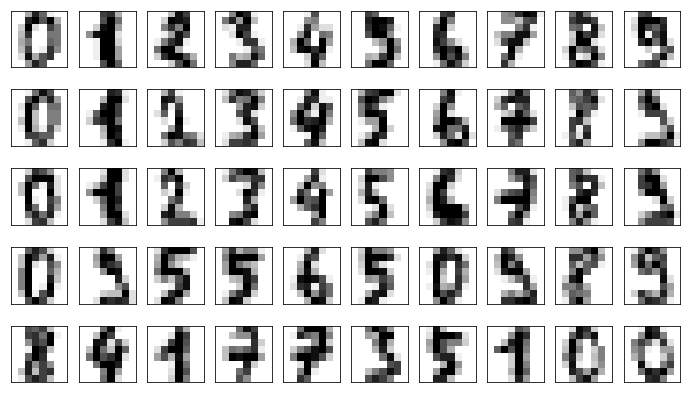

In [9]:
# Plot the first 50 images and show the corresponding labels
fig, axes = plt.subplots(5, 10, figsize=(12, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap=plt.cm.gray_r)

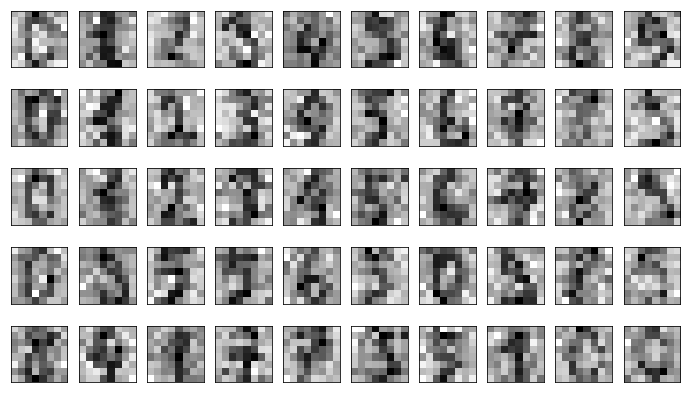

In [10]:
# Introduce random noise to the dataset and plot the results
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
fig, axes = plt.subplots(5, 10, figsize=(12, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(noisy[i].reshape(8, 8), cmap=plt.cm.gray_r)

In [11]:
# Use PCA to reduce the number of dimensions
pca = PCA(0.5).fit(noisy)
pca.n_components_

12

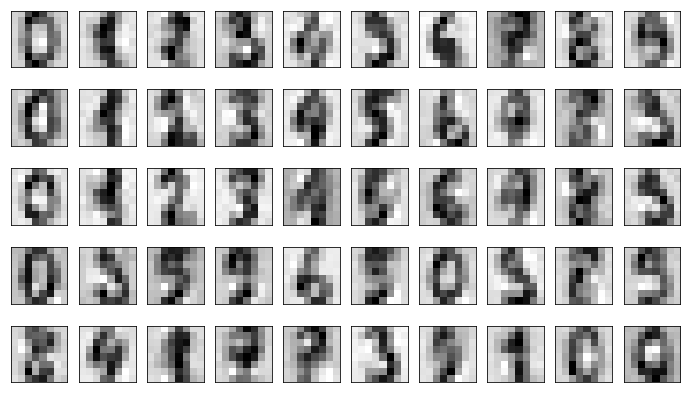

In [12]:
# Reconstruct the dataset from the reduced version
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)

fig, axes = plt.subplots(5, 10, figsize=(12, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(filtered[i].reshape(8, 8), cmap=plt.cm.gray_r)